In [1]:
## https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb
name = "R09725049_吳延東"
timestep = 8

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c ntu-homework3  --force
! unzip /content/ntu-homework3.zip

  0% 0.00/327k [00:00<?, ?B/s]
100% 327k/327k [00:00<00:00, 91.8MB/s]
Archive:  /content/ntu-homework3.zip
  inflating: testing_x.npy           
  inflating: training_x.npy          
  inflating: training_y.npy          


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from scipy import stats
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Multiply, Layer, dot
from keras.utils import plot_model
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import matplotlib.pyplot as plt

seed = 5566
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
def make_data(data, timestep, data_type = 'x'):
    query_dim = 2
    if data_type == 'x':
        assert data.ndim == query_dim
        return (np.array([data[i:i+timestep] for i in range(data.shape[0]-(2*timestep))]))
    elif data_type == 'y':
        assert data.ndim == query_dim
        return (np.array([data[i+timestep:i+(2*timestep)] for i in range(data.shape[0]-(2*timestep))]))
    else:
        print('incorrect data type')
        return None

In [5]:
#AMB_TEMP, CO, NO, NO2, NOx, O3, PM10, RAINFALL, RH, SO2, THC ,cos_wind, sin_wind
timestep = 8
training_x = np.load('training_x.npy')
testing_x = np.load('testing_x.npy')
training_y = np.load('training_y.npy')
# testing_y = np.load('testing_y.npy')

In [6]:
## 結果最後發現沒有做 feature engineering 的結果比較好
training_x_shift = make_data(training_x, timestep, data_type = 'x')
testing_x_shift = make_data(testing_x, timestep, data_type = 'x')
# training_x_shift = make_data(feature_engineering(training_x, pm10=False), timestep, data_type = 'x')
# testing_x_shift = make_data(feature_engineering(testing_x, pm10=False), timestep, data_type = 'x')
print(training_x_shift.shape, testing_x_shift.shape)

training_y_shift = make_data(training_y, timestep, data_type = 'y')
print(training_y_shift.shape)

(8744, 8, 13) (8744, 8, 13)
(8744, 8, 1)


In [ ]:
rnn = models.Sequential()

rnn.add(layers.Input(shape=(training_x_shift.shape[1], training_x_shift.shape[2])))
## Add a LSTM layer with 32 internal units.
## 用 softplus 比較符合我想保留 x 而且有正的 y
rnn.add(layers.LSTM(32, dropout=0.1, return_sequences=True, activation="softplus", kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3)))
rnn.add(layers.LayerNormalization(axis=-1))
# 運用 layer normalization 來處理資料散佈有極端值的問題
rnn.add(layers.LSTM(256, dropout=0.1, return_sequences=False, activation="softplus", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-2)))
rnn.add(layers.LayerNormalization(axis=-1))
rnn.add(layers.Dense(32))
rnn.add(layers.Dropout(.2))
## 最後一層輸出
rnn.add(layers.Dense(8))

In [ ]:
## record the cost of time
t0 = time.time()
# 因為 epoch 跑比較多次，所以 learning rate 調比較小
rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss=tf.keras.losses.MeanSquaredError())

# Model weights are saved at the end of every epoch, if it's the best seen so far.
# And early stop in 2 epochs

checkpoint_filepath = '%s.h5' %name
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]

# The model weights (that are considered the best) are loaded into the model.
rnn_history = rnn.fit(
    training_x_shift, training_y_shift, epochs=500, validation_split=0.2, shuffle=True, batch_size=64, workers=8, use_multiprocessing=True, 
    callbacks=my_callbacks
    )

rnn.load_weights(checkpoint_filepath)
t1 = time.time()
print("---training finished, time cost: %d min---" %((t1-t0)/60))

Epoch 1/500
110/110 [==============================] - 41s 343ms/step - loss: 234.2921 - val_loss: 172.7928
Epoch 2/500
110/110 [==============================] - 7s 66ms/step - loss: 150.8701 - val_loss: 144.4559
Epoch 3/500
110/110 [==============================] - 7s 66ms/step - loss: 139.3823 - val_loss: 188.2772
Epoch 4/500
110/110 [==============================] - 7s 66ms/step - loss: 134.9692 - val_loss: 148.4297
Epoch 5/500
110/110 [==============================] - 7s 64ms/step - loss: 130.0090 - val_loss: 145.9429
Epoch 6/500
110/110 [==============================] - 7s 65ms/step - loss: 127.6753 - val_loss: 153.5354
Epoch 7/500
110/110 [==============================] - 7s 65ms/step - loss: 122.6451 - val_loss: 149.7421
Epoch 8/500
110/110 [==============================] - 7s 65ms/step - loss: 122.1378 - val_loss: 132.4479
Epoch 9/500
110/110 [==============================] - 7s 65ms/step - loss: 120.0112 - val_loss: 137.5618
Epoch 10/500
110/110 [======================

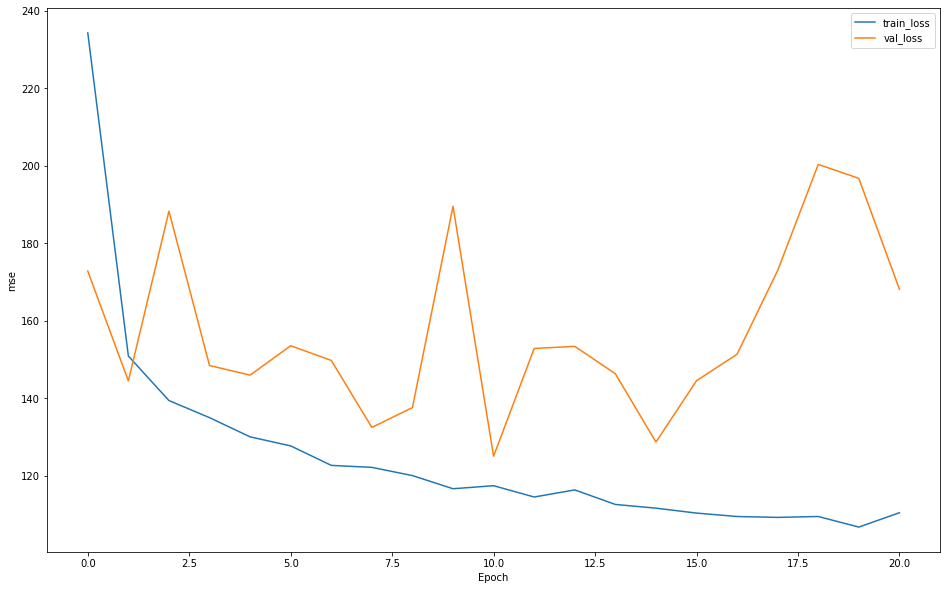

In [ ]:
## 訓練的 loss 圖
plt.figure(figsize=(16, 10))
plt.plot(rnn_history.history['loss'], label='train_loss')
plt.plot(rnn_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(loc='upper right')

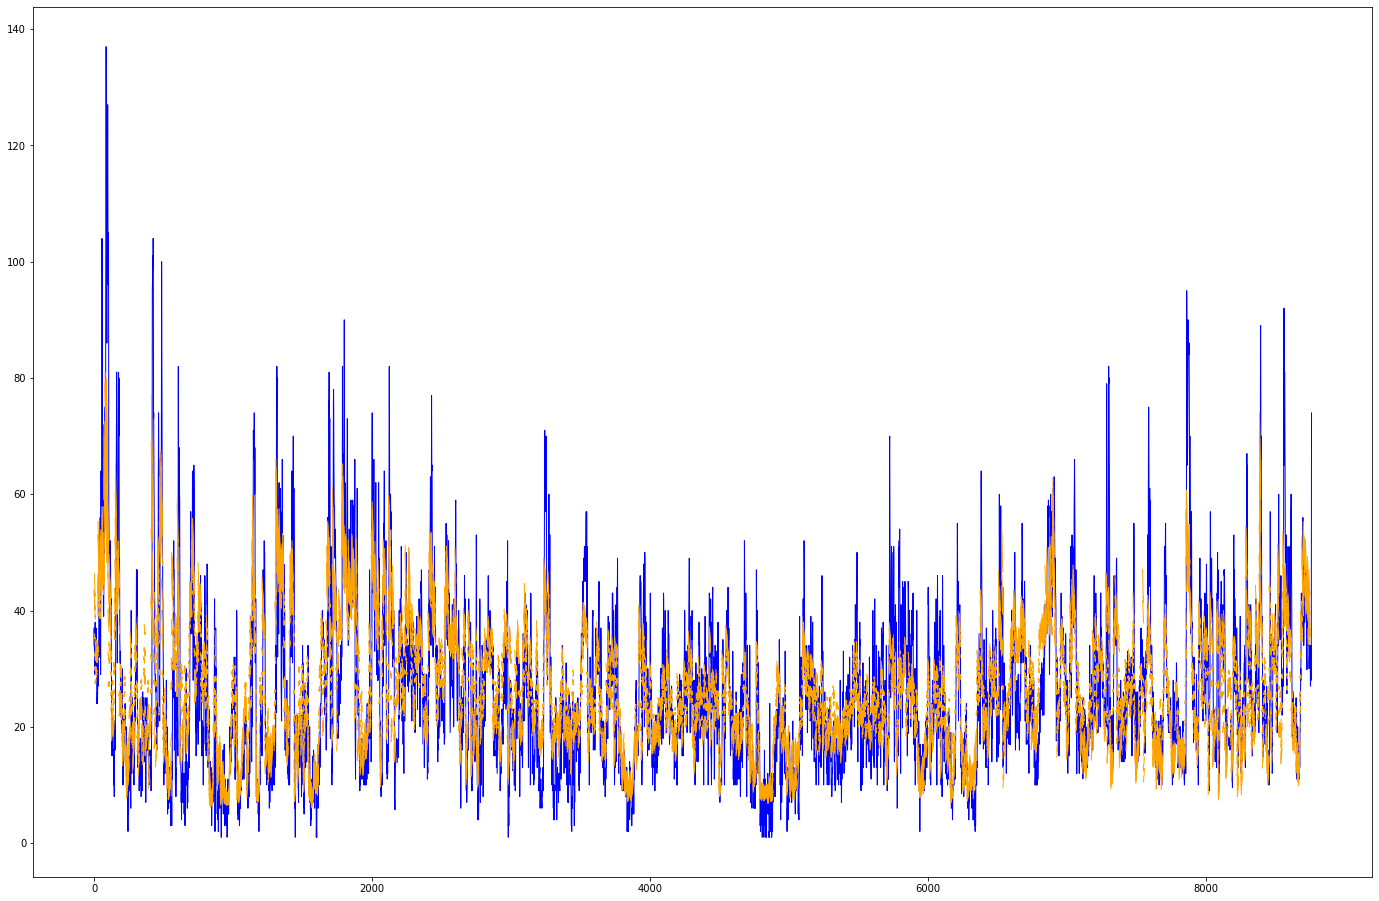

---training finished, time cost: 3 min---


In [ ]:
## 毛毛蟲圖
training_pred = rnn.predict(training_x_shift,)
plt.figure(figsize=(24, 16))
plt.plot(training_y, lw=1, c="b")
for i in range(training_pred.shape[0]):
  plt.plot([i+j for j in range(8)], training_pred[i], lw=1, c="orange")
plt.show()
t1 = time.time()
print("---training finished, time cost: %d min---" %((t1-t0)/60))

In [ ]:
pd.DataFrame(training_pred)

,0,1,2,3,4,5,6,7
0,52.097229,52.326565,51.468452,50.318329,50.415791,48.936413,48.968204,48.005890
1,50.919106,51.130371,50.295483,49.183746,49.291981,47.830029,47.881035,46.944355
2,52.113510,52.381279,51.505638,50.372562,50.470432,48.967762,49.019867,48.049847
3,47.269760,47.590355,46.898438,45.969955,46.091091,44.810619,44.948032,44.114357
4,41.275963,41.663963,41.136150,40.451286,40.605228,39.599819,39.814404,39.158829
...,...,...,...,...,...,...,...,...
8739,34.174458,34.335403,33.956982,33.372082,33.506836,32.764931,32.819424,32.401890
8740,33.898705,34.091469,33.727383,33.193031,33.311855,32.619167,32.708912,32.283104
8741,31.989227,32.197350,31.876852,31.459591,31.583002,30.983067,31.091978,30.714567
8742,26.475140,26.767776,26.617197,26.480284,26.765570,26.362066,26.568174,26.327108


In [ ]:
idx = [i+1 for i in range(8744)]
col = ["PM2.5-%s" %(i+1) for i in range(8)]
testing_pred = rnn.predict(testing_x_shift,)
pred_df = pd.DataFrame(testing_pred, index=idx, columns=col)
pred_df["INDEX"] = [i+1 for i in range(8744)]
pred_df.to_csv("%s.csv" %name, index=False)
pred_df

,PM2.5-1,PM2.5-2,PM2.5-3,PM2.5-4,PM2.5-5,PM2.5-6,PM2.5-7,PM2.5-8,INDEX
1,31.153168,30.455008,30.673231,30.704758,30.203598,29.747879,30.223986,29.744761,1
2,33.295635,32.581821,32.761505,32.671860,32.095146,31.567623,32.018726,31.483824,2
3,32.197678,31.424875,31.509558,31.544090,30.969584,30.539913,30.919748,30.391901,3
4,33.871170,32.989723,32.974045,32.977951,32.317188,31.900242,32.109802,31.538233,4
5,28.641701,28.006853,28.182394,28.343155,27.882557,27.565693,28.001188,27.595446,5
...,...,...,...,...,...,...,...,...,...
8740,31.185089,30.683775,30.815107,31.094763,30.606663,30.372437,30.672155,30.314199,8740
8741,38.891323,38.153503,37.944584,37.935516,37.120899,36.788029,36.736080,36.153599,8741
8742,44.623356,43.739639,43.297726,43.059807,41.977486,41.567062,41.212910,40.516483,8742
8743,52.719803,51.758560,51.070950,50.381279,48.939362,48.287273,47.609684,46.734821,8743


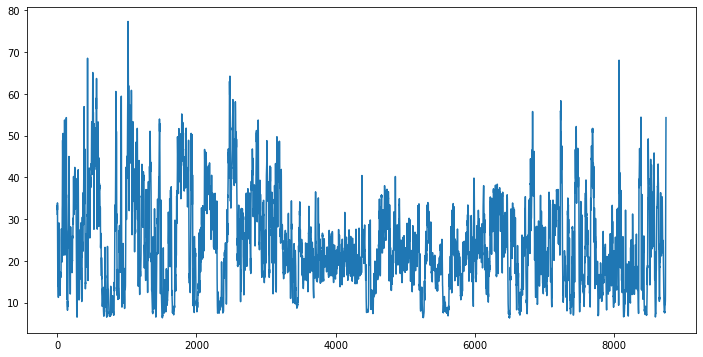

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pred_df["PM2.5-1"])

In [ ]:
! kaggle competitions submit -c ntu-homework3 -f R09725049_吳延東.csv -m "Message"

100% 706k/706k [00:00<00:00, 2.73MB/s]
Successfully submitted to NTU Homework3

## Seq2seq

In [33]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.lstm1 = layers.LSTM(16,return_sequences = True, return_state=True)
        self.lstm2 = layers.LSTM(16,return_sequences = False, return_state=True)
    
    def call(self, inp):        
        self.x = self.lstm1(inp)
        self.encoder_last_h1, self.encoder_last_h2, self.encoder_last_c = self.lstm2(self.x)
        return self.encoder_last_h1, self.encoder_last_h2, self.encoder_last_c 
    
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.lstm3 = layers.LSTM(units = 16, return_sequences = True,  return_state = False)
        self.lstm4 = layers.LSTM(units = 16,  return_state = False)
        self.dense = layers.Dense(8)
        
    def call(self, inp):
        self.d_inp = inp[0] 
        self.initial_state = [inp[1], inp[2]]
        lstm_output = self.lstm3(self.d_inp,initial_state = self.initial_state)
        lstm_output = self.lstm4(lstm_output,initial_state = self.initial_state)
        return self.dense(lstm_output)

In [34]:
class Sequence2Sequence(tf.keras.Model):
    def __init__(self):
        super(Sequence2Sequence,self).__init__()
        self.Encoder = Encoder()
        self.Decoder = Decoder()
        
    def call(self, inp):

        encoder_outputs = self.Encoder.call(inp)      
        outputs = self.Decoder.call(encoder_outputs)

        
        return outputs

In [39]:
s2s_model = Sequence2Sequence()

Early = EarlyStopping(
    monitor='val_loss', min_delta=0, 
    patience=20, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)

filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
mode='min')

checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose=1, save_best_only=True, mode='min', save_weights_only =True)
s2s_model.compile(optimizer=tf.keras.optimizers.Adam(0.003, decay=0.0001), loss="mse", metrics=["mse"])
history = s2s_model.fit(x = training_x_shift, 
                        y = training_y_shift, epochs=100, 
                        verbose = 1, validation_split=0.2,  
                        callbacks=[Early, checkpoint])
s2s_model.summary()

Epoch 1/100
217/219 [============================>.] - ETA: 0s - loss: 584.5141 - mse: 584.5141
Epoch 1: val_mse improved from inf to 498.09390, saving model to weights-improvement.hdf5
219/219 [==============================] - 16s 26ms/step - loss: 582.7787 - mse: 582.7787 - val_loss: 498.0939 - val_mse: 498.0939
Epoch 2/100
217/219 [============================>.] - ETA: 0s - loss: 322.6883 - mse: 322.6883
Epoch 2: val_mse improved from 498.09390 to 307.95016, saving model to weights-improvement.hdf5
219/219 [==============================] - 4s 18ms/step - loss: 321.2991 - mse: 321.2991 - val_loss: 307.9502 - val_mse: 307.9502
Epoch 3/100
219/219 [==============================] - ETA: 0s - loss: 246.8380 - mse: 246.8380
Epoch 3: val_mse improved from 307.95016 to 244.38988, saving model to weights-improvement.hdf5
219/219 [==============================] - 4s 18ms/step - loss: 246.8380 - mse: 246.8380 - val_loss: 244.3899 - val_mse: 244.3899
Epoch 4/100
216/219 [==================

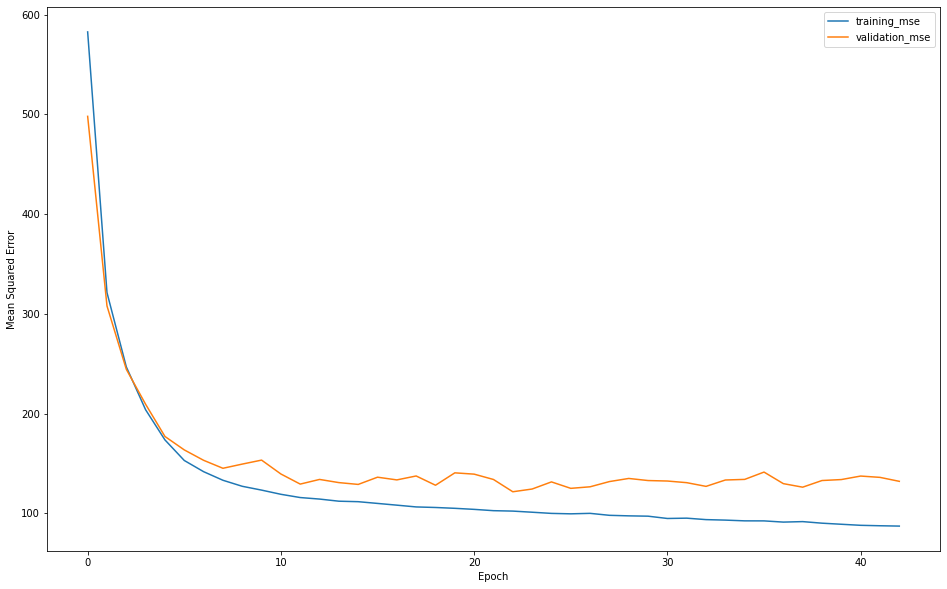

In [40]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'], label='training_mse')
plt.plot(history.history['val_loss'], label = 'validation_mse')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend(loc='upper right')

In [37]:
s2s_model.load_weights("weights-improvement.hdf5")
training_pred = s2s_model.predict(training_x_shift)
testing_pred = s2s_model.predict(testing_x_shift)

274/274 [==============================] - 1s 5ms/step


In [41]:
y_pred = pd.DataFrame(testing_pred)
y_pred.columns = ['PM2.5-'+str(i+1) for i in range(8)]
y_pred['INDEX'] = list(range(1,len(y_pred)+1))
y_pred = y_pred[['INDEX','PM2.5-1','PM2.5-2','PM2.5-3','PM2.5-4','PM2.5-5','PM2.5-6','PM2.5-7','PM2.5-8']]
y_pred

,INDEX,PM2.5-1,PM2.5-2,PM2.5-3,PM2.5-4,PM2.5-5,PM2.5-6,PM2.5-7,PM2.5-8
0,1,36.660915,36.317966,36.131840,35.740711,35.184074,35.512108,35.429375,34.471996
1,2,36.660885,36.317940,36.131813,35.740688,35.184052,35.512077,35.429352,34.471966
2,3,36.660728,36.317757,36.131634,35.740551,35.183846,35.511868,35.429150,34.471771
3,4,36.660656,36.317669,36.131550,35.740490,35.183754,35.511768,35.429054,34.471684
4,5,36.660587,36.317596,36.131477,35.740429,35.183670,35.511677,35.428970,34.471603
...,...,...,...,...,...,...,...,...,...
8739,8740,23.953215,24.298864,24.294701,24.355202,24.226479,24.267670,24.317945,24.471291
8740,8741,36.443676,36.110264,35.935596,35.546425,35.014656,35.324669,35.237667,34.310436
8741,8742,36.654789,36.311287,36.125916,35.734180,35.179924,35.506756,35.423615,34.467876
8742,8743,36.658218,36.314957,36.129200,35.737762,35.182320,35.509750,35.426811,34.470253
